# GRU_eda


## Mount Google Drive

In [ ]:
# Colab 사용시
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install

In [ ]:
# !java -version
# %pip install PyKomoran
%pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 629 kB/s 
     |████████████████████████████████| 453 kB 62.1 MB/s 


## Import Library

In [ ]:
# data
import pandas as pd
import pickle

# preprocessing
from konlpy.tag import Komoran
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# model
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# evaluation
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# visualization
import matplotlib.pyplot as plt
import seaborn as sn

# env
import os
from tqdm import tqdm
# import hangul_font

## GPU Setting

In [ ]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


## Hyper_parameters

In [ ]:
# Colab
DATA_DIR = '/content/drive/MyDrive/miso/sentiment/data/'
SAVE_DIR = '/content/drive/MyDrive/miso/sentiment/model/GRU_eda/'
LOAD_DIR = '/content/drive/MyDrive/miso/sentiment/model/GRU_eda/'

# Model
# MAX_LEN -> 패딩 단계에서 설정
OUTPUT_DIM = 512 #Embedding
UNITS = 256 #GRU
DROPOUT = 0.2 #GRU
OUTPUT = 6 #Dense

# Evaluation
EPOCHS = 10
VERBOSE = 1
BATCH_SIZE = 512
PATIENCE = 4
VALIDATION_SPLIT = 0.2

## Load Data

In [ ]:
df = pd.read_csv(DATA_DIR+'eda_final_sentiment.csv')

In [ ]:
df[:1]

,text,label
0,"어, 청소 니가 대신 해 줘!",angry


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 667870 entries, 0 to 667869
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    667870 non-null  object
 1   label   667870 non-null  object
dtypes: object(2)
memory usage: 10.2+ MB


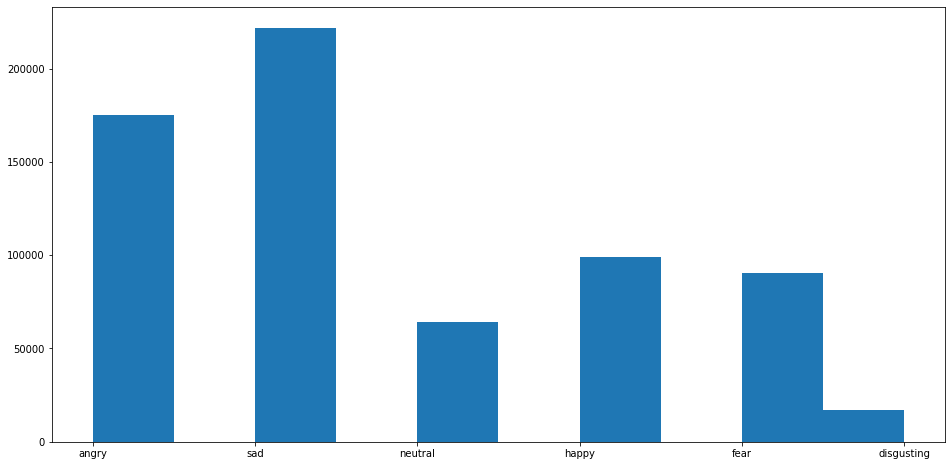

In [ ]:
label = df['label']

plt.figure(figsize=(16, 8))
plt.hist(label)
plt.show()

## Train, Test split

In [ ]:
X = df.text
y = df.label

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=34, stratify=y
)

In [ ]:
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('\nX_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)

X_train shape:  (534296,)
y_train shape:  (534296,)

X_test shape:  (133574,)
y_test shape:  (133574,)


## Train Data PreProcessing

### Tokenization

In [ ]:
komoran = Komoran()

# 불용어(Stop Words) 제거
stop_pos_tags =  ['IC', 'JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX',
                   'EF', 'ETN', 'ETM', 'XSA', 'SF', 'SP', 'SS', 'SE', 'SO', 'SL', 'SH',
                   'SW', 'NF', 'NV', 'SN', 'NA']

#어간 원형 복원 (Lemmatization)
#동사와 형용사의 경우에는 어간(Stem)에 '다'를 붙여서 기본형으로 복원
def tokenize(corpus, stop_pos_tags):
    result = []
    pairs = komoran.pos(corpus)
    for pair in pairs:
        morph, pos = pair
        if pos not in stop_pos_tags:
            if pos in ['VV', 'VA', 'VX', 'VCP', 'VCN']:
                morph = morph + '다'
            result.append(morph)
    return result

In [ ]:
# 토큰을 만들고 리스트에 저장
clean_train_text = []
for sample in tqdm(X_train):
    clean_train_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 534296/534296 [06:45<00:00, 1316.18it/s]


In [ ]:
clean_train_text[:3]

[['근데', '면접', '오히려', '더', '잘', '보다', '았'],
 ['많이', '놀라다', '았'],
 ['앉다', '아서', '일', '하다', '니까', '허리', '너무', '아프다']]

## Test Data PreProcessing

### Tokenization

In [ ]:
# 토큰을 만들고 리스트에 저장
clean_test_text = []
for sample in tqdm(X_test):
    clean_test_text.append(tokenize(sample, stop_pos_tags))

100%|██████████| 133574/133574 [02:02<00:00, 1094.01it/s]


## Vectorization

In [ ]:
tokenizer_name = 'tokenizer.pickle'
save_path = os.path.join(SAVE_DIR, tokenizer_name)

tokenizer = Tokenizer(oov_token = True)

try:
    tokenizer.fit_on_texts(clean_train_text)
    train_sequences = tokenizer.texts_to_sequences(clean_train_text)
    test_sequences = tokenizer.texts_to_sequences(clean_test_text)
except:
    print('Already tokenized')

with open(save_path, 'wb') as f:
    pickle.dump(tokenizer, f, protocol=pickle.HIGHEST_PROTOCOL)

train_sequences[:3]

[[206, 230, 890, 63, 42, 21, 5],
 [53, 229, 5],
 [687, 15, 32, 3, 82, 351, 13, 109]]

### Set vocab_size

In [ ]:
VOCAB_SIZE = len(tokenizer.word_index) + 1
print(VOCAB_SIZE)

13268


### Get vocab items

In [ ]:
token_dic = tokenizer.word_counts
d2 = sorted(token_dic.items(), key=lambda x: x[1], reverse=True)
print("sorted")
print(d2)

sorted
[('하', 227391), ('하다', 191735), ('고', 163025), ('았', 149174), ('었', 120822), ('이다', 109469), ('나', 100135), ('게', 98876), ('는데', 97986), ('아', 88468), ('있다', 87915), ('너무', 82245), ('내', 81031), ('아서', 78243), ('어', 73280), ('것', 69931), ('같다', 67939), ('들', 64525), ('어서', 59654), ('보다', 58241), ('친구', 57610), ('없다', 57087), ('되다', 56774), ('지', 56756), ('안', 53908), ('겠', 47490), ('않다', 41646), ('주다', 41568), ('좋다', 40099), ('나다', 38521), ('일', 37648), ('거', 34756), ('사람', 31990), ('가다', 31217), ('아야', 31000), ('다', 29955), ('말', 28874), ('싶다', 28464), ('면', 28428), ('들다', 28049), ('잘', 27784), ('수', 27521), ('지다', 26966), ('생각', 26587), ('모르다', 25492), ('받다', 25126), ('오다', 24475), ('힘들다', 23865), ('정말', 23768), ('그렇다', 23702), ('되', 23171), ('많이', 20930), ('다고', 20760), ('회사', 20151), ('때', 20146), ('한', 20122), ('시', 19829), ('못', 19734), ('걸다', 19525), ('ㄴ데', 19500), ('걱정', 19472), ('더', 18496), ('그', 18182), ('집', 17928), ('돈', 17429), ('마음', 16983), ('알다', 16743), ('지금', 

## Padding

텍스트의 최대 길이 : 62
텍스트의 평균 길이 : 12.660396110021411


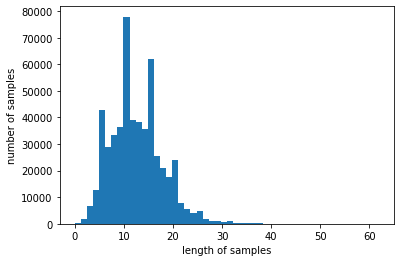

In [ ]:
print('텍스트의 최대 길이 :',max(len(text) for text in train_sequences))
print('텍스트의 평균 길이 :',sum(map(len, train_sequences))/len(train_sequences))
plt.hist([len(text) for text in train_sequences], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
trunc_type = 'post'
padding_type = 'post'
MAX_LEN = int(max(len(text) for text in train_sequences) * 95 / 100)

X_train = pad_sequences(train_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)
X_test= pad_sequences(test_sequences, maxlen=MAX_LEN, padding=padding_type, truncating=trunc_type)

In [ ]:
print(X_train[:3])

[[206 230 890  63  42  21   5   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [ 53 229   5   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]
 [687  15  32   3  82 351  13 109   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0]]


### Labeling

In [ ]:
y_train.unique()

array(['happy', 'fear', 'sad', 'angry', 'neutral', 'disgusting'],
      dtype=object)

In [ ]:
emo_dic = {
    'angry': 0, 'disgusting': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5
}

In [ ]:
y_train = y_train.replace(emo_dic)
y_test = y_test.replace(emo_dic)
y_train.unique()

array([3, 2, 5, 0, 4, 1])

## Model definition

In [41]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=OUTPUT_DIM, mask_zero=True, input_length=MAX_LEN))
model.add(GRU(units=UNITS, dropout=DROPOUT))
model.add(Dense(units=OUTPUT, activation='softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=VERBOSE, patience=PATIENCE, restore_best_weights=True)
mcp = ModelCheckpoint(SAVE_DIR + 'best-model.h5', monitor='val_accuracy', mode='max', verbose=VERBOSE, save_best_only=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train Model

In [42]:
history = model.fit(
    X_train, y_train, epochs=EPOCHS, callbacks=[es,mcp], batch_size=BATCH_SIZE, validation_split=VALIDATION_SPLIT
)

Epoch 1/10
833/835 [============================>.] - ETA: 0s - loss: 0.4920 - accuracy: 0.8210
Epoch 1: val_accuracy improved from -inf to 0.88101, saving model to /content/drive/MyDrive/miso/sentiment/model/GRU_eda/best-model.h5
835/835 [==============================] - 42s 32ms/step - loss: 0.4915 - accuracy: 0.8212 - val_loss: 0.3297 - val_accuracy: 0.8810
Epoch 2/10
833/835 [============================>.] - ETA: 0s - loss: 0.3025 - accuracy: 0.8933
Epoch 2: val_accuracy improved from 0.88101 to 0.90275, saving model to /content/drive/MyDrive/miso/sentiment/model/GRU_eda/best-model.h5
835/835 [==============================] - 22s 26ms/step - loss: 0.3025 - accuracy: 0.8933 - val_loss: 0.2795 - val_accuracy: 0.9028
Epoch 3/10
833/835 [============================>.] - ETA: 0s - loss: 0.2629 - accuracy: 0.9083
Epoch 3: val_accuracy improved from 0.90275 to 0.90608, saving model to /content/drive/MyDrive/miso/sentiment/model/GRU_eda/best-model.h5
835/835 [==========================

## Test Model

In [43]:
loaded_model = load_model(SAVE_DIR + 'best-model.h5')
loss, acc = loaded_model.evaluate(X_test, y_test)

print('Test loss:', loss)
print('Test accuracy:', acc)

4175/4175 [==============================] - 19s 4ms/step - loss: 0.2265 - accuracy: 0.9291
Test loss: 0.2265113741159439
Test accuracy: 0.9290730357170105


## Visualization

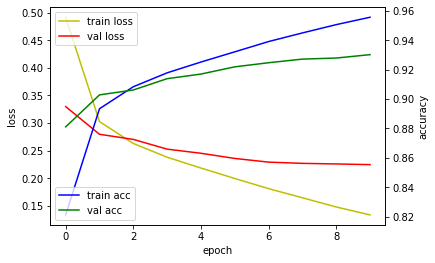

In [44]:
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

## Save Model

In [45]:
model_name = 'trained-model.h5'

# Save model and weights
model_path = os.path.join(SAVE_DIR, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at /content/drive/MyDrive/miso/sentiment/model/GRU_eda/trained-model.h5 


## Evaluation

confusion matrix

In [46]:
y_pred = loaded_model.predict(X_test)
y_pred = y_pred.argmax(axis=-1)
print(y_pred)

[5 5 5 ... 2 4 5]


[[32826    77   291   268   343  1192]
 [   98  3039    63    31    71    93]
 [  334    45 16691   157   194   701]
 [  385    27   244 18116   339   715]
 [  287    91   212   210 11567   487]
 [ 1028    36   464   569   422 41861]]


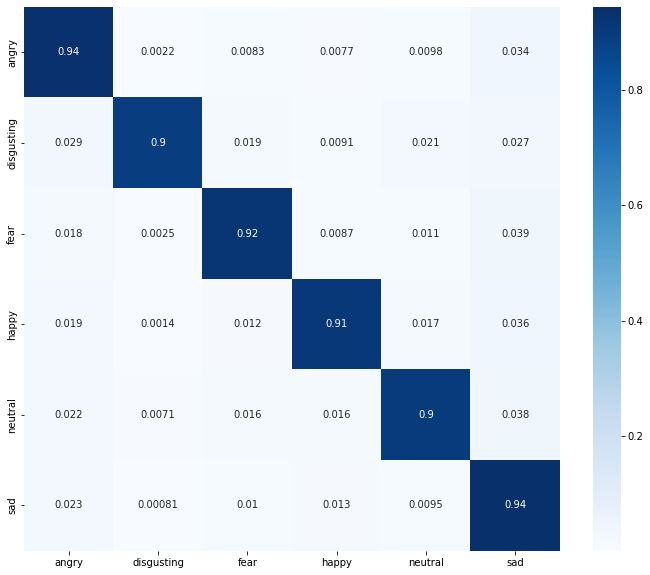

In [47]:
# constant for classes
classes = ('angry', 'disgusting', 'fear', 'happy', 'neutral', 'sad')

# Build confusion matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
df_cm = pd.DataFrame(cf_matrix/cf_matrix.sum(axis=1).reshape(6, 1), index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,10))
sn.heatmap(df_cm, annot=True, cmap='Blues')
plt.savefig(SAVE_DIR + '/output.png')

precision, recall, f1 score

In [48]:
acc_score = accuracy_score(y_test, y_pred)
prec_score = precision_score(y_test, y_pred, average='macro')
re_score = recall_score(y_test, y_pred, average='macro')
f1_score = f1_score(y_test, y_pred, average='macro')
print("accuracy_score: ", acc_score)
print("precision_score: ", prec_score)
print("recall_score: ", re_score)
print("f1_score: ", f1_score)

accuracy_score:  0.9290730231931363
precision_score:  0.9240703114184448
recall_score:  0.9185010956612754
f1_score:  0.9212283683195087


## Load Model

In [51]:
def load_tokenizer(path):
    with open(path, 'rb') as f:
        tokenizer = pickle.load(f)
    return tokenizer

model_name = 'trained-model.h5'
tokenizer_name = 'tokenizer.pickle'
model_path = os.path.join(LOAD_DIR, model_name)
tokenizer_path = os.path.join(LOAD_DIR, tokenizer_name)

model = load_model(model_path)
tokenizer = load_tokenizer(tokenizer_path)


In [52]:
def getResult(predict) :
    highest = 0
    highestIdx = 0
    for x in range (0,len(predict)) :
        if(predict[x] > highest) :
            highestIdx = x
            highest =predict[x]
    return highestIdx

def predict_sentiment(text, model):
    tokens = []
    tokenized = tokenize(text, stop_pos_tags)
    if(len(tokenized) == 0) :
        return "너무 짧아"
    tokens.append(tokenized)
    tokens = tokenizer.texts_to_sequences(tokens)
    x_test = pad_sequences(tokens, maxlen=MAX_LEN)
    predict = model.predict(x_test)
    # print(predict)
    result = getResult(predict[0])
    if result == 0 :
        return 'angry'
    elif result == 1 :
        return 'disgusting'
    elif result == 2 :
        return 'fear'
    elif result == 3 :
        return 'happy'
    elif result == 4 :
        return 'neutral'
    elif result == 5 :
        return 'sad'

# TEST

angry 라벨에 대한 예측

In [53]:
predict_sentiment("연락이 또 안돼. 짜증난다.", model)

'angry'

disgusting 라벨에 대한 예측

In [54]:
predict_sentiment("음식물 냄새가 너무 심해.", model)

'disgusting'

fear 라벨에 대한 예측

In [55]:
predict_sentiment("갑자기 떠날까봐 걱정이야.", model)

'fear'

happy라벨에 대한 예측

In [56]:
predict_sentiment("부모님께서 건강하다는 사실에 대해 감사하고 있어.", model)

'happy'

neutral라벨에 대한 예측

In [57]:
predict_sentiment("지금 밥 먹으러 가는중이야.", model)

'neutral'

sad라벨에 대한 예측

In [58]:
predict_sentiment("루비가 세상을 떠났어.", model)

'sad'

## 결과